In [30]:
from collections import deque

from parse import parse
from pathlib import Path

import pandas as pd

summary_df_rows = deque()
samples_df_rows = deque()
for txt in Path("./").glob("*.txt"):
    name_parse = parse("results_{mean_ms:d}_{jitter_ms:d}_{correl_pcnt:d}.txt", txt.name)
    mean_latency = 2 * name_parse["mean_ms"] / 1000.0
    jitter = 2 * name_parse["jitter_ms"] / 1000.0
    rho = name_parse["correl_pcnt"] / 100.0
    
    row = {
        "target_mean_latency": mean_latency,
        "jitter": jitter,
        "rho": rho,
    }
    
    with txt.open("r") as fp:
        lines = fp.readlines()
        assert(len(lines) == 1004)
        
        for sample_row in lines[1:-3]:
            sample_parse = parse(
                "{_:d} bytes from 127.0.0.1: icmp_seq={seq:d} ttl={_:d} time={rtt:f} ms",
                sample_row.strip()
            )
            samples_df_rows.append({
                "target_mean_latency": mean_latency,
                "jitter": jitter,
                "rho": rho,
                "seq": sample_parse["seq"],
                "rtt": sample_parse["rtt"] / 1000.0,
            })
        
        summary = lines[-1].strip()
        summary_parse = parse(
            "round-trip min/avg/max/stddev = {min_lat:f}/{avg_lat:f}/{max_lat:f}/{std_lat:f} ms",
            summary,
        )
        row.update({
            "actual_mean_latency": summary_parse["avg_lat"] / 1000.0,
            "std_latency": summary_parse["std_lat"] / 1000.0,
            "min_latency": summary_parse["min_lat"] / 1000.0,
            "max_latency": summary_parse["max_lat"] / 1000.0,
        })
    
    summary_df_rows.append(row)
    
# stationary parameters don't seem to change with correlation, awesome
summary_results = pd.DataFrame(summary_df_rows).groupby([
    "target_mean_latency",
    "jitter",
])["std_latency"].mean()
summary_results

target_mean_latency  jitter
0.1                  0.02      0.012517
0.2                  0.04      0.023106
0.4                  0.08      0.045524
0.8                  0.16      0.092714
1.6                  0.32      0.179005
3.2                  0.64      0.377754
Name: std_latency, dtype: float64

In [67]:
import scipy.stats as st

fit_result_rows = deque()
for (mean, jitter), df in pd.DataFrame(samples_df_rows).groupby(["target_mean_latency", "jitter"]):
    fit_result = st.fit(st.pareto, df["rtt"], bounds={"b": (2, 10), "scale": (0.05, 5.0)})
    assert fit_result.success
    fit_result_rows.append({
        "mean": mean,
        "jitter": jitter,
        "shape": fit_result.params.b,
        "scale": fit_result.params.scale
    })
    
fits_df = pd.DataFrame(fit_result_rows)
fits_df.to_csv('./fits.csv', index=False)
fits_df

,mean,jitter,shape,scale
0,0.1,0.02,4.497600,0.088346
1,0.2,0.04,6.257237,0.177206
2,0.4,0.08,6.836943,0.351322
3,0.8,0.16,7.751845,0.701636
4,1.6,0.32,7.689716,1.394286
5,3.2,0.64,7.592262,2.783705


Mean 0.10 | Jitter 0.02 | ACF 0.50


/Users/molguin/.venvs/EdgeDroid/lib/python3.11/site-packages/generate_corr_sequence/generate_corr_sequence.py:46: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  I = quad(integration_function, integration_min, integration_max, args=(numberOfHermitePoly, dist_obj))
/Users/molguin/.venvs/EdgeDroid/lib/python3.11/site-packages/generate_corr_sequence/generate_corr_sequence.py:46: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  I = quad(integration_function, integration_min, integration_max, args=(numberOfHermitePoly, dist_obj))


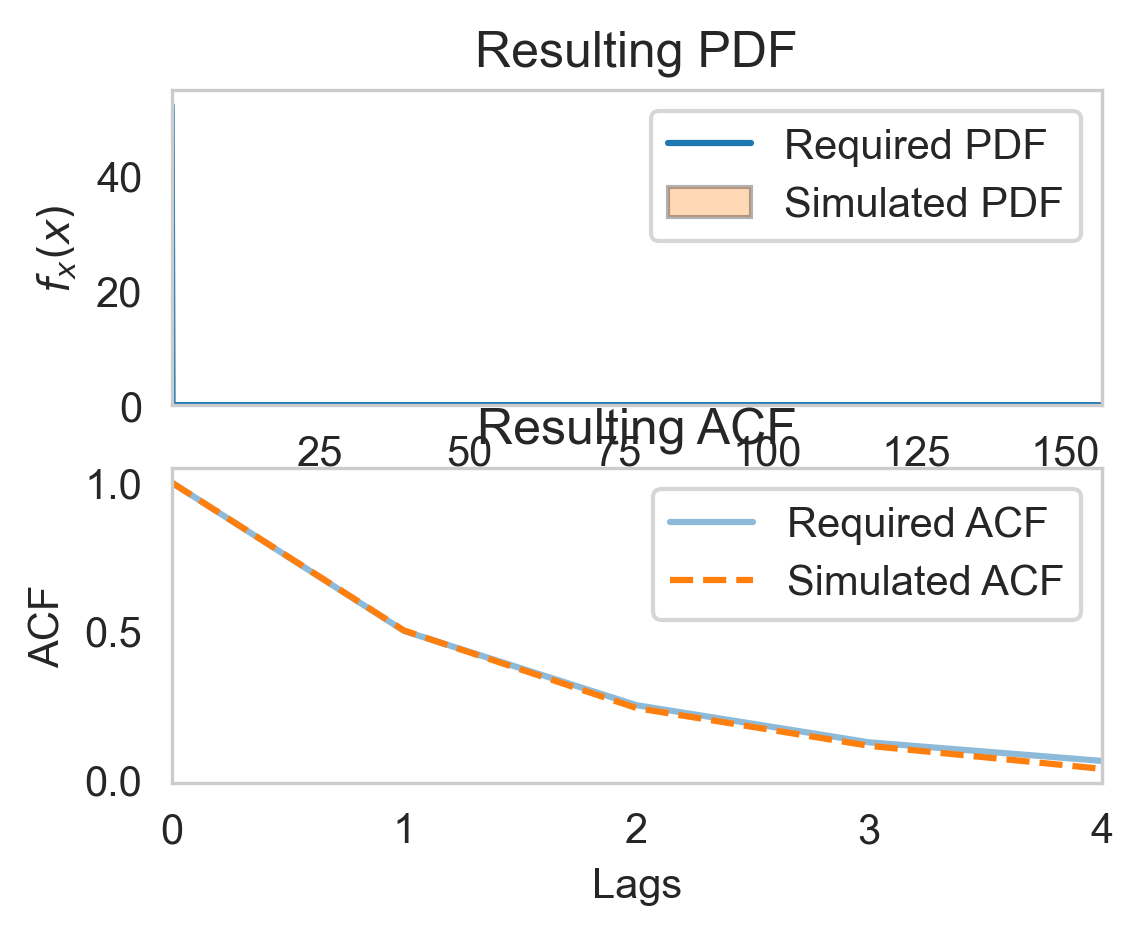

Mean 0.20 | Jitter 0.04 | ACF 0.50


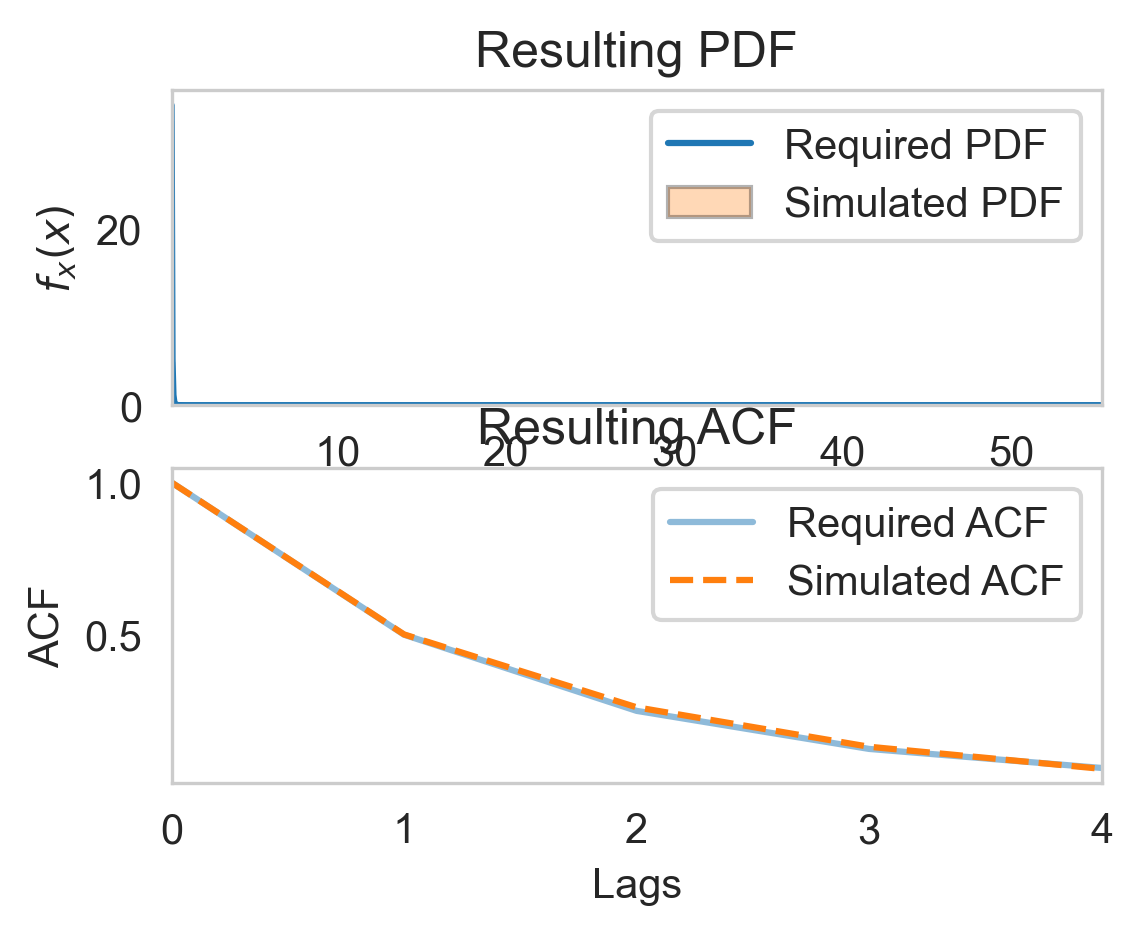

Mean 0.40 | Jitter 0.08 | ACF 0.50


/Users/molguin/.venvs/EdgeDroid/lib/python3.11/site-packages/generate_corr_sequence/generate_corr_sequence.py:46: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  I = quad(integration_function, integration_min, integration_max, args=(numberOfHermitePoly, dist_obj))


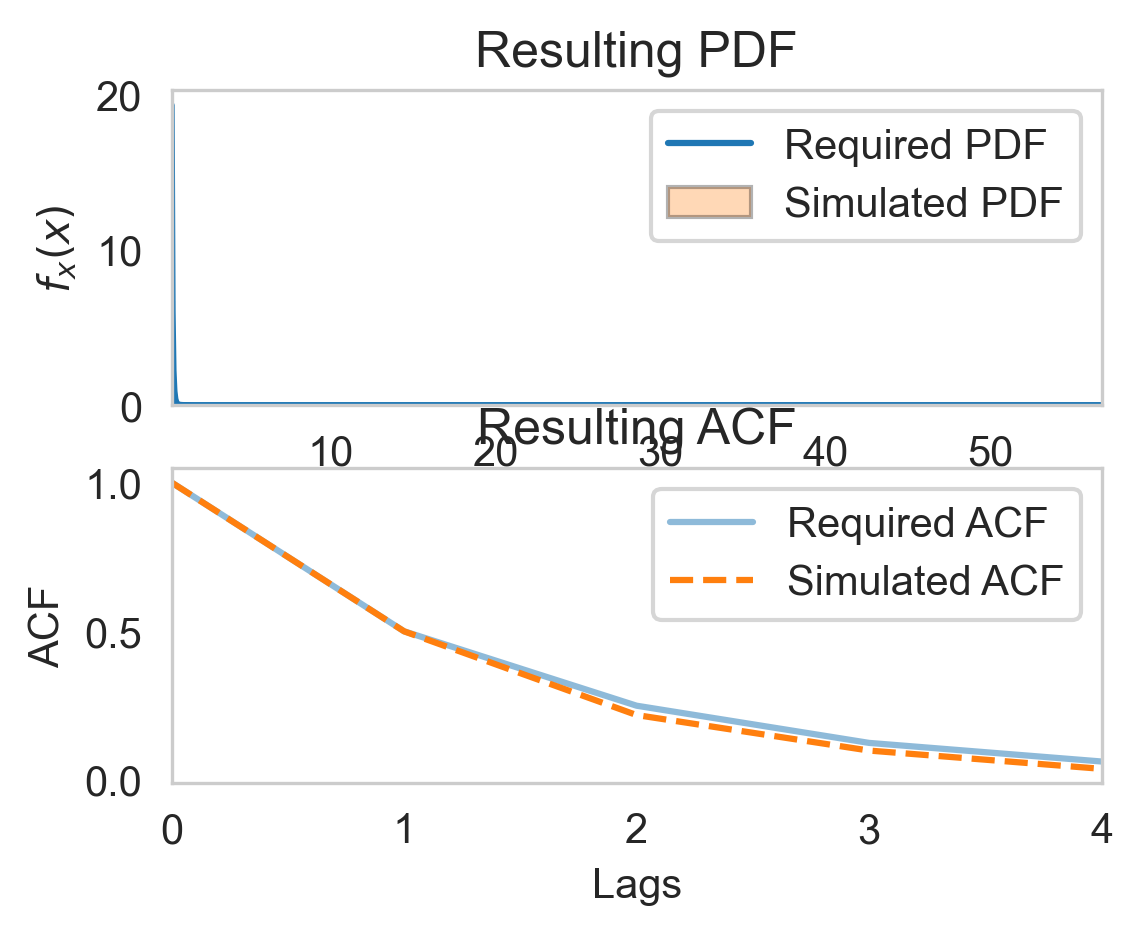

Mean 0.80 | Jitter 0.16 | ACF 0.50


/Users/molguin/.venvs/EdgeDroid/lib/python3.11/site-packages/generate_corr_sequence/generate_corr_sequence.py:46: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  I = quad(integration_function, integration_min, integration_max, args=(numberOfHermitePoly, dist_obj))


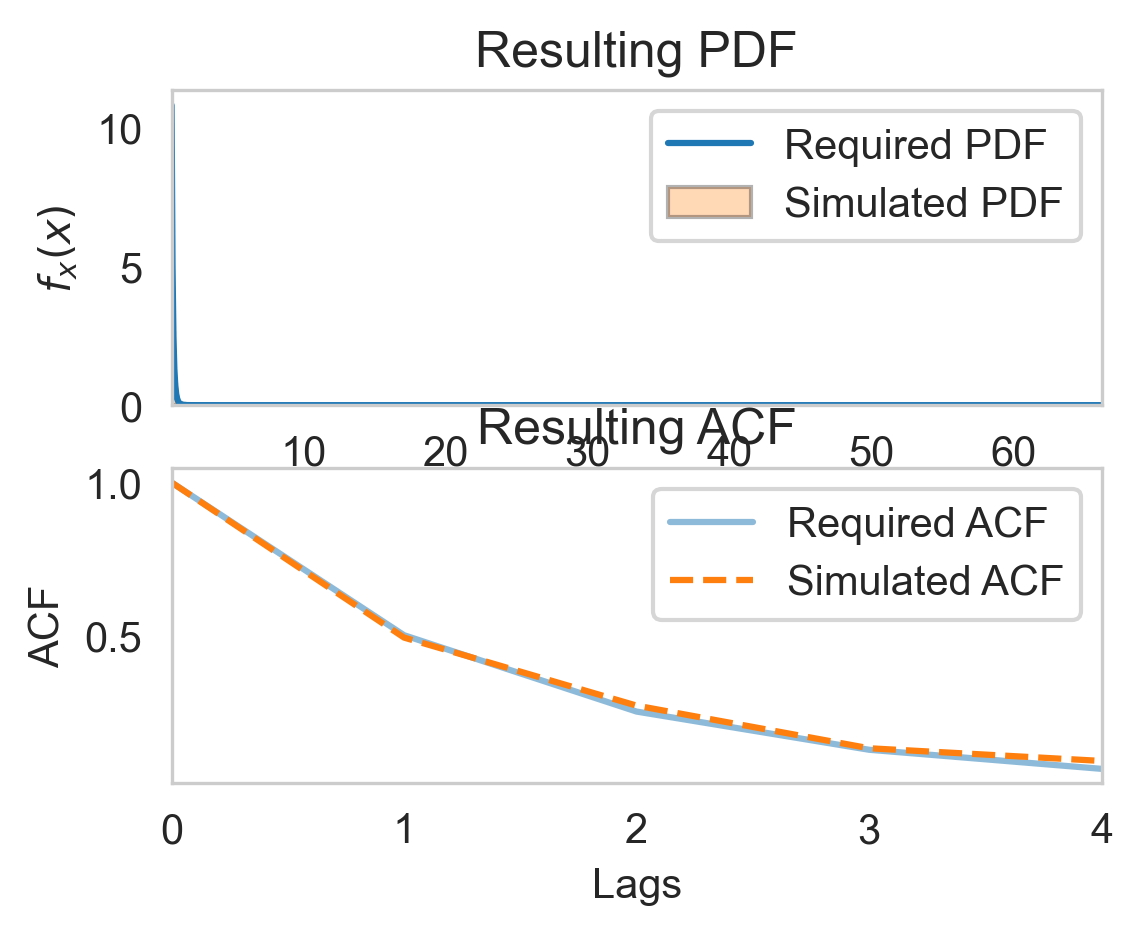

Mean 1.60 | Jitter 0.32 | ACF 0.50


/Users/molguin/.venvs/EdgeDroid/lib/python3.11/site-packages/generate_corr_sequence/generate_corr_sequence.py:46: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  I = quad(integration_function, integration_min, integration_max, args=(numberOfHermitePoly, dist_obj))


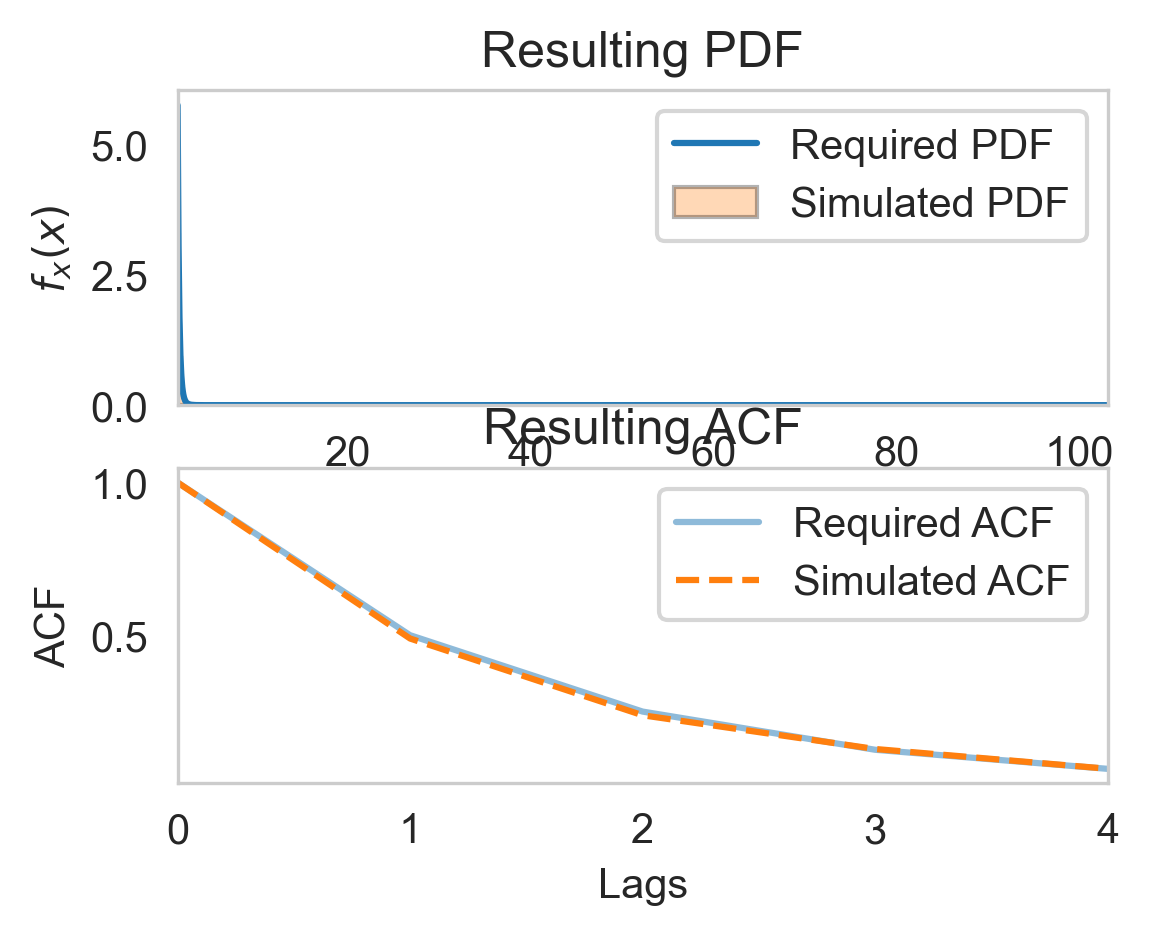

Mean 3.20 | Jitter 0.64 | ACF 0.50


/Users/molguin/.venvs/EdgeDroid/lib/python3.11/site-packages/generate_corr_sequence/generate_corr_sequence.py:46: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  I = quad(integration_function, integration_min, integration_max, args=(numberOfHermitePoly, dist_obj))
/Users/molguin/.venvs/EdgeDroid/lib/python3.11/site-packages/generate_corr_sequence/generate_corr_sequence.py:46: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  I = quad(integration_function, integration_min, integration_max, args=(numberOfHermitePoly, dist_obj))


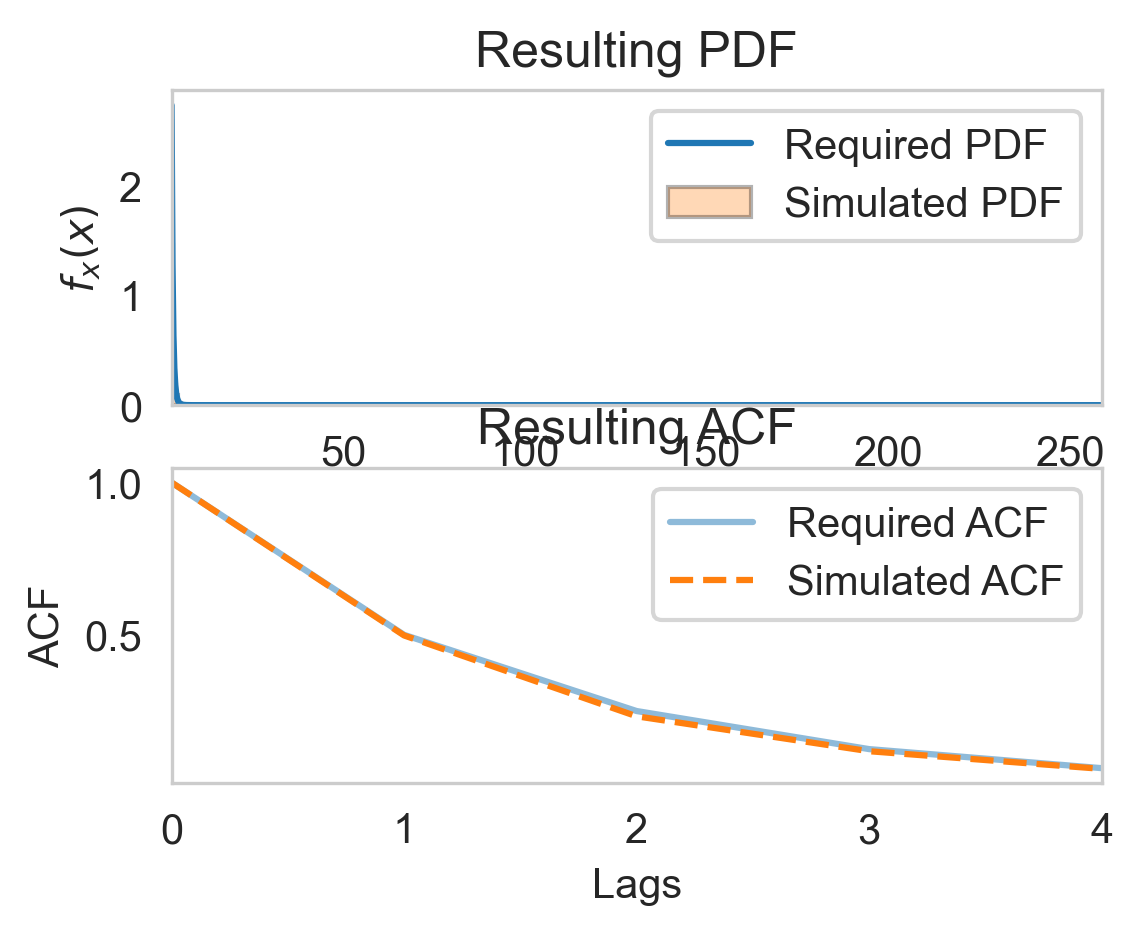

Mean 0.10 | Jitter 0.02 | ACF 0.25


/Users/molguin/.venvs/EdgeDroid/lib/python3.11/site-packages/generate_corr_sequence/generate_corr_sequence.py:46: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  I = quad(integration_function, integration_min, integration_max, args=(numberOfHermitePoly, dist_obj))
/Users/molguin/.venvs/EdgeDroid/lib/python3.11/site-packages/generate_corr_sequence/generate_corr_sequence.py:46: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  I = quad(integration_function, integration_min, integration_max, args=(numberOfHermitePoly, dist_obj))


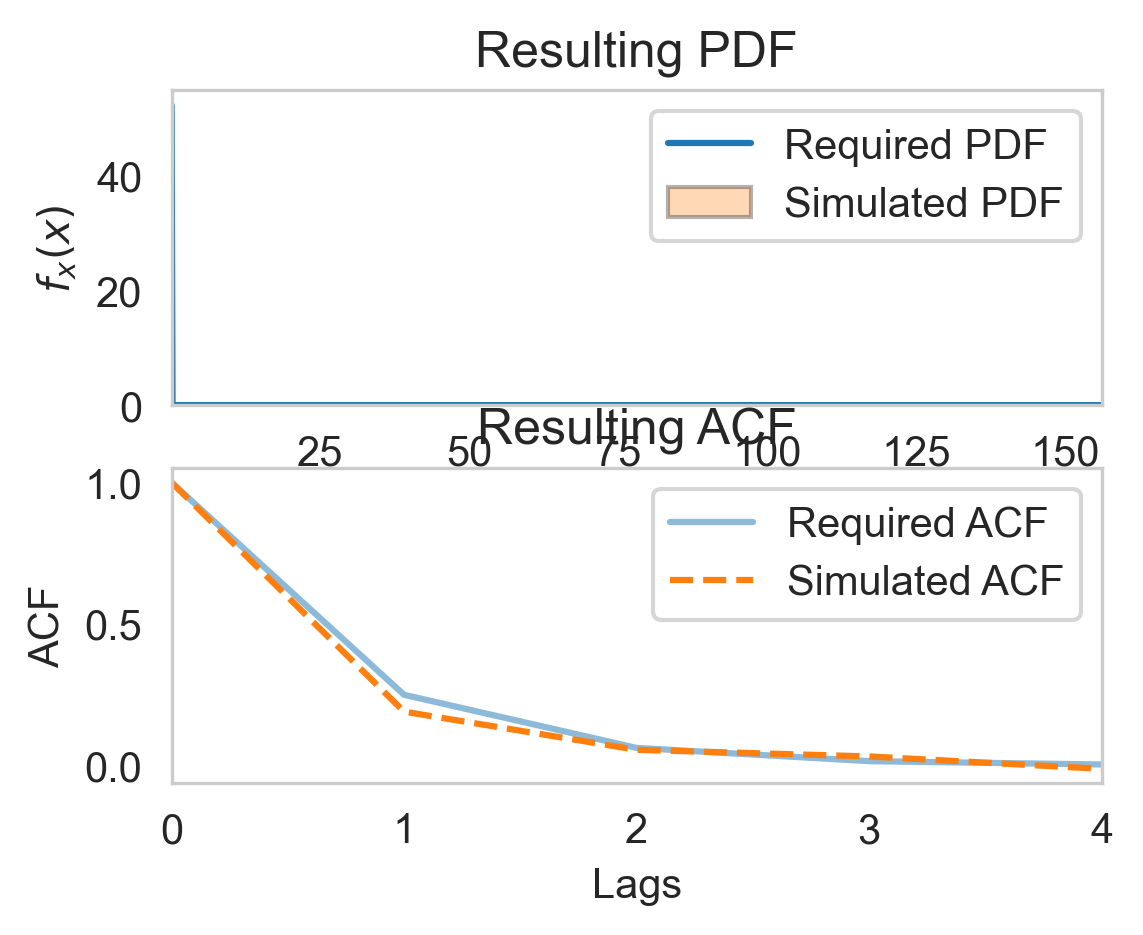

Mean 0.20 | Jitter 0.04 | ACF 0.25


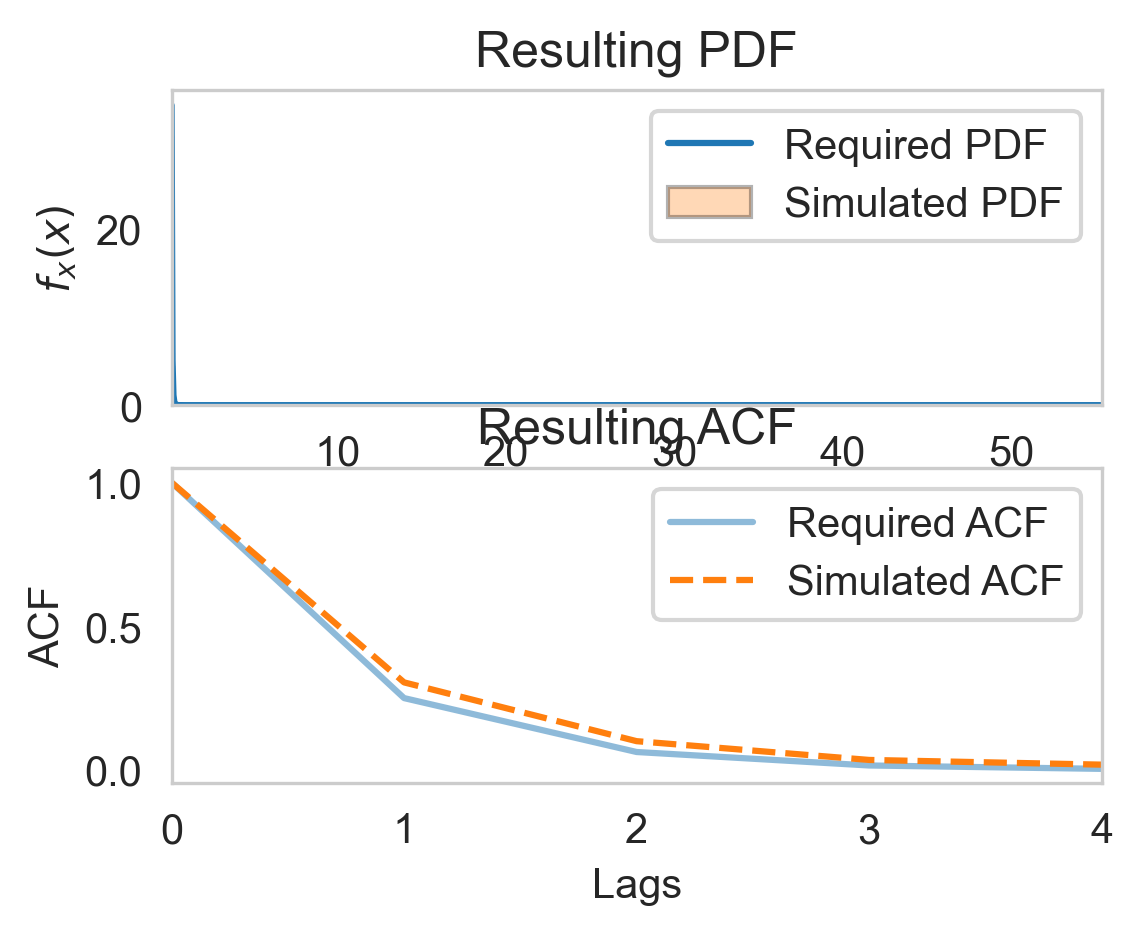

Mean 0.40 | Jitter 0.08 | ACF 0.25


/Users/molguin/.venvs/EdgeDroid/lib/python3.11/site-packages/generate_corr_sequence/generate_corr_sequence.py:46: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  I = quad(integration_function, integration_min, integration_max, args=(numberOfHermitePoly, dist_obj))


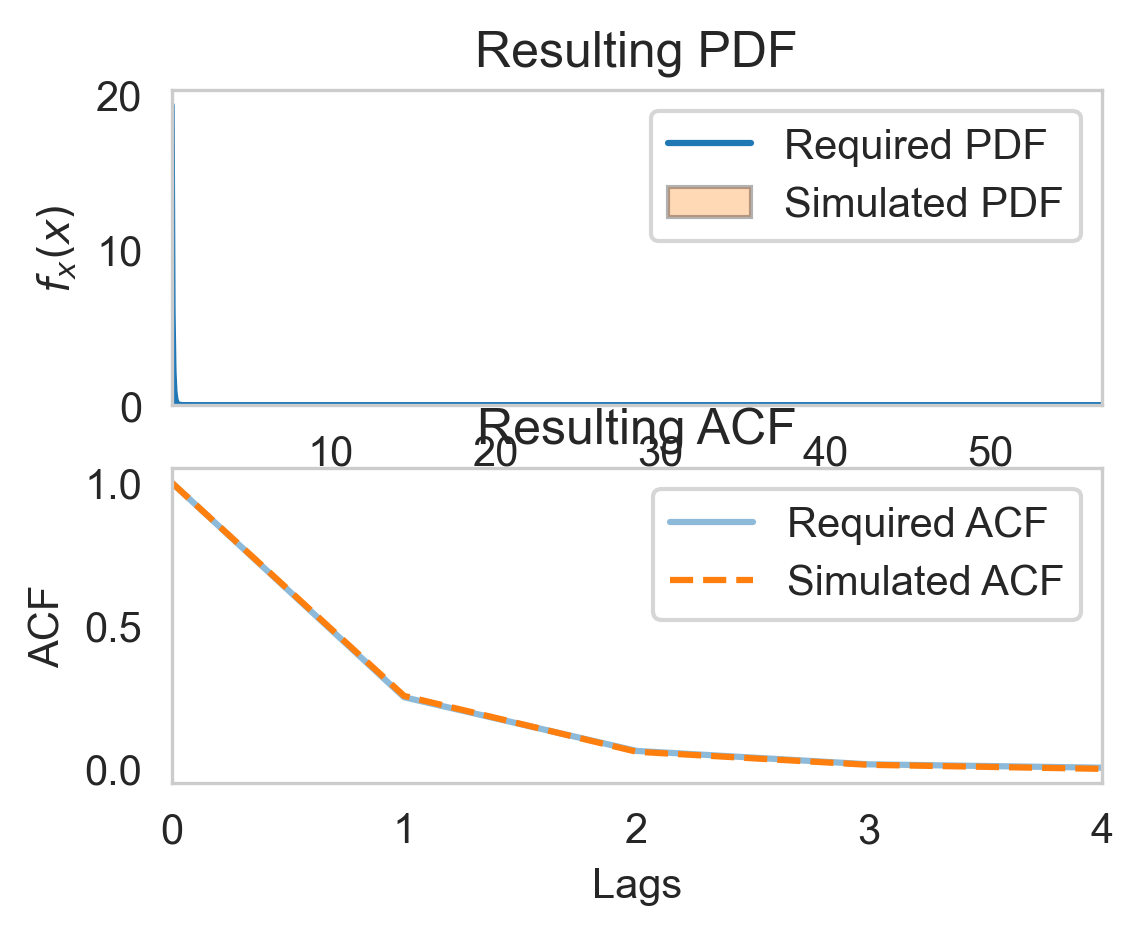

Mean 0.80 | Jitter 0.16 | ACF 0.25


/Users/molguin/.venvs/EdgeDroid/lib/python3.11/site-packages/generate_corr_sequence/generate_corr_sequence.py:46: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  I = quad(integration_function, integration_min, integration_max, args=(numberOfHermitePoly, dist_obj))


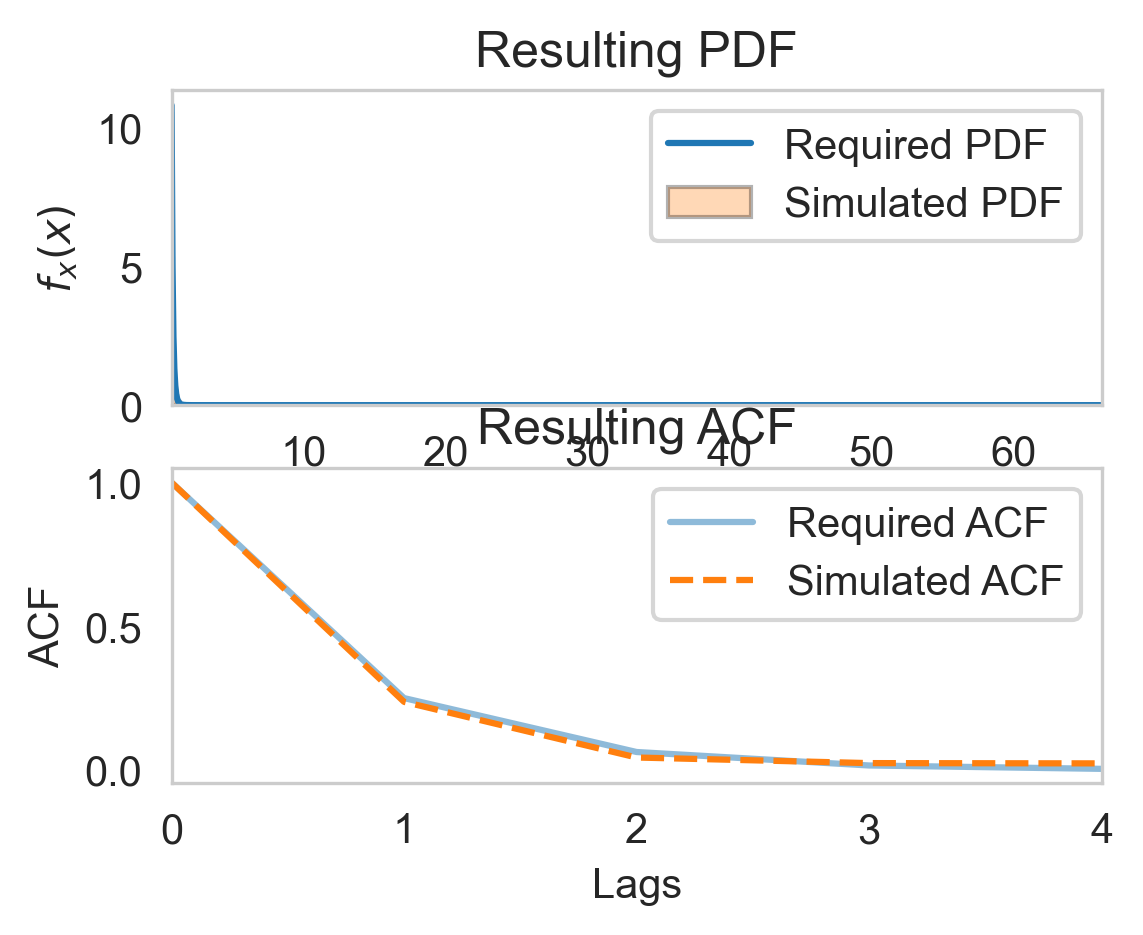

Mean 1.60 | Jitter 0.32 | ACF 0.25


/Users/molguin/.venvs/EdgeDroid/lib/python3.11/site-packages/generate_corr_sequence/generate_corr_sequence.py:46: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  I = quad(integration_function, integration_min, integration_max, args=(numberOfHermitePoly, dist_obj))


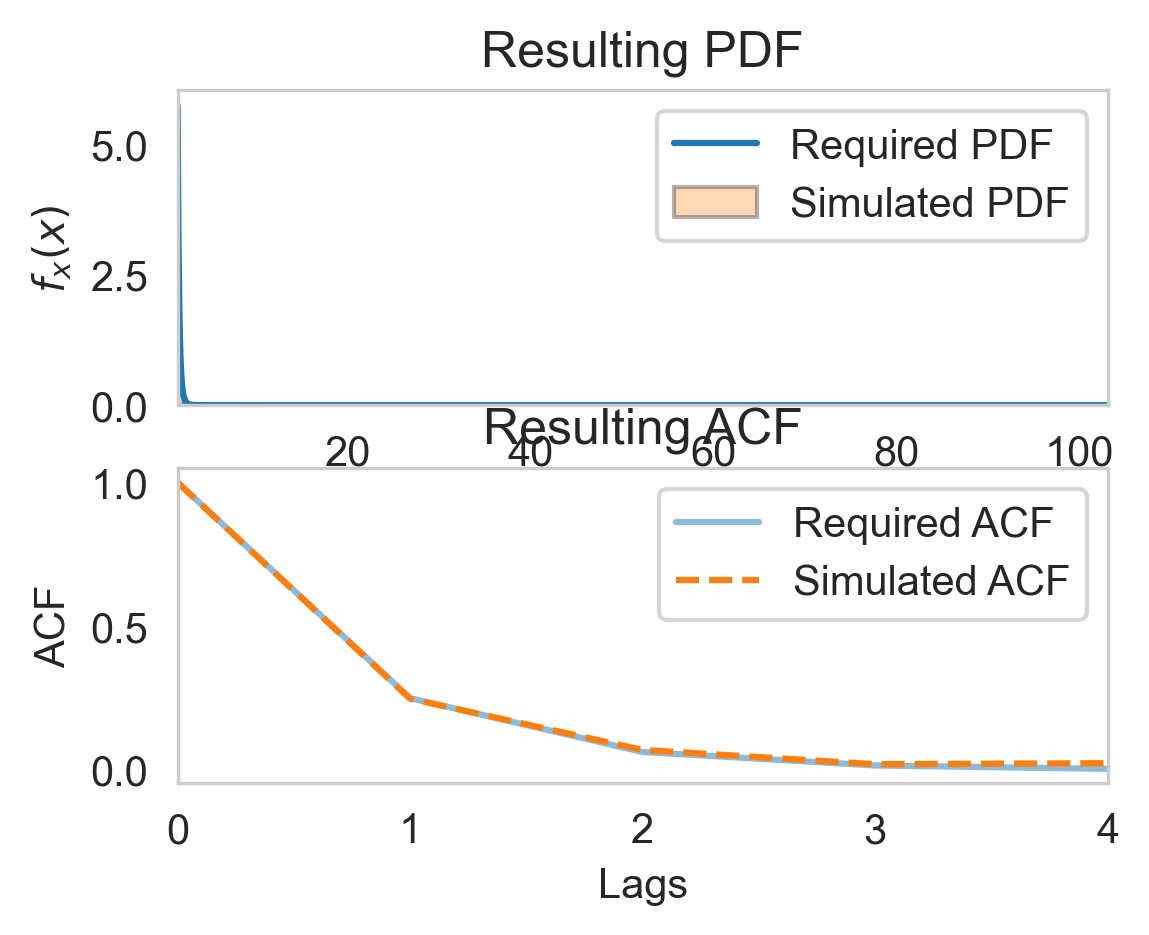

Mean 3.20 | Jitter 0.64 | ACF 0.25


/Users/molguin/.venvs/EdgeDroid/lib/python3.11/site-packages/generate_corr_sequence/generate_corr_sequence.py:46: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  I = quad(integration_function, integration_min, integration_max, args=(numberOfHermitePoly, dist_obj))
/Users/molguin/.venvs/EdgeDroid/lib/python3.11/site-packages/generate_corr_sequence/generate_corr_sequence.py:46: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  I = quad(integration_function, integration_min, integration_max, args=(numberOfHermitePoly, dist_obj))


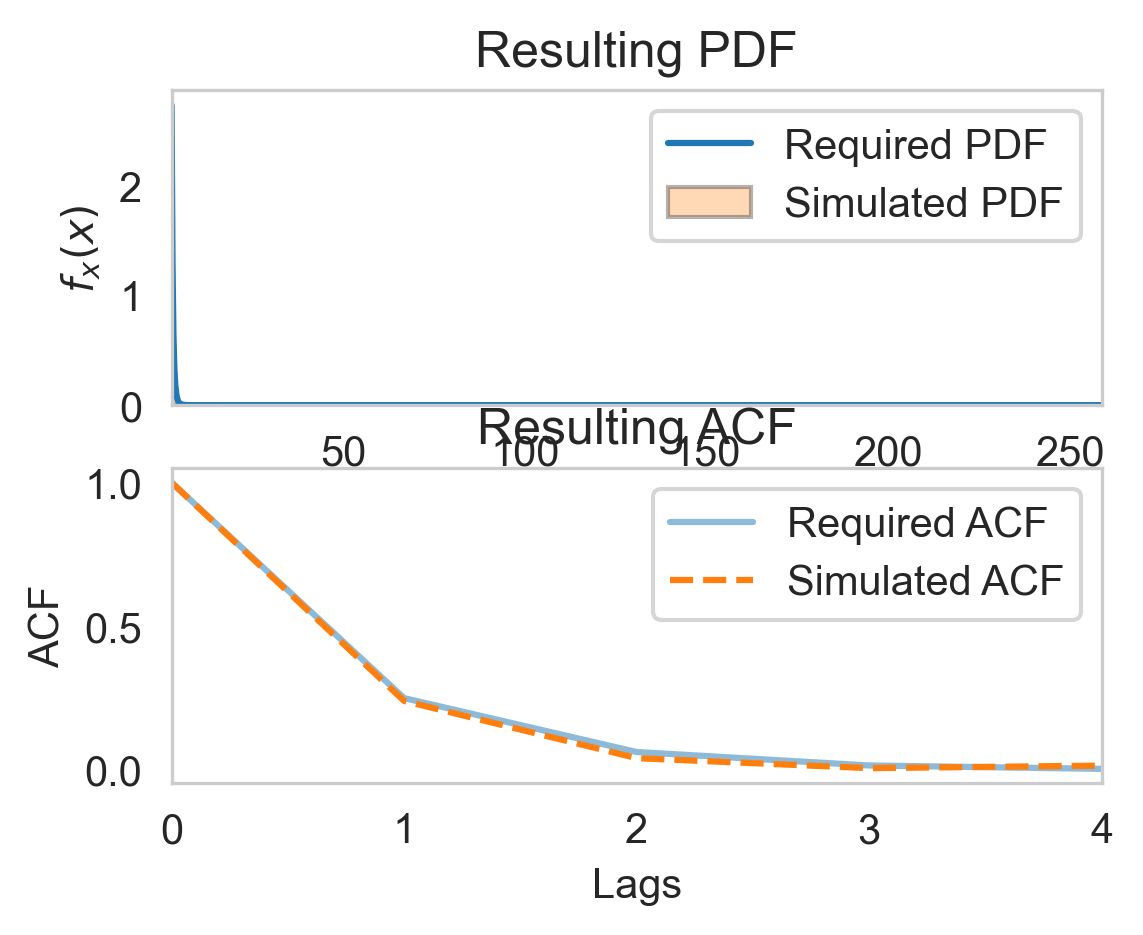

Mean 0.10 | Jitter 0.02 | ACF 0.12


/Users/molguin/.venvs/EdgeDroid/lib/python3.11/site-packages/generate_corr_sequence/generate_corr_sequence.py:46: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  I = quad(integration_function, integration_min, integration_max, args=(numberOfHermitePoly, dist_obj))
/Users/molguin/.venvs/EdgeDroid/lib/python3.11/site-packages/generate_corr_sequence/generate_corr_sequence.py:46: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  I = quad(integration_function, integration_min, integration_max, args=(numberOfHermitePoly, dist_obj))


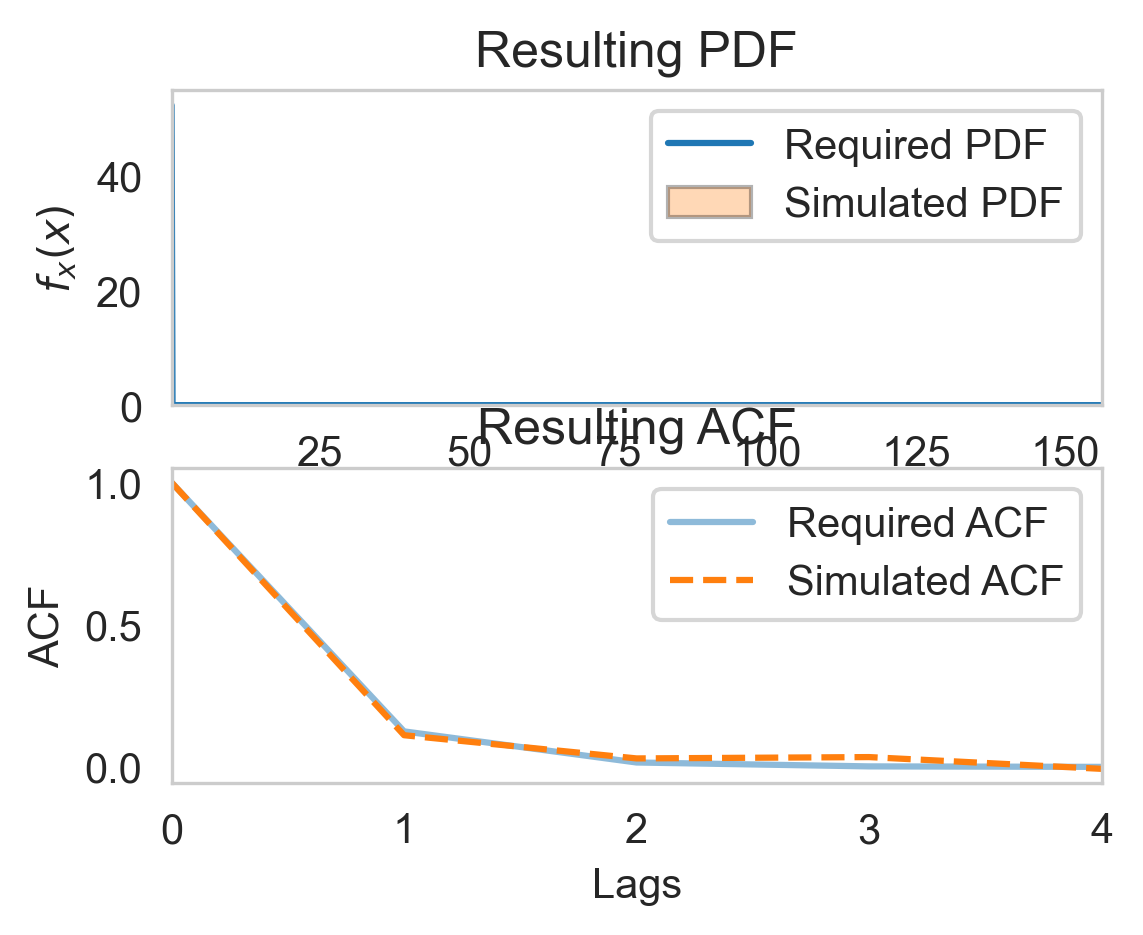

Mean 0.20 | Jitter 0.04 | ACF 0.12


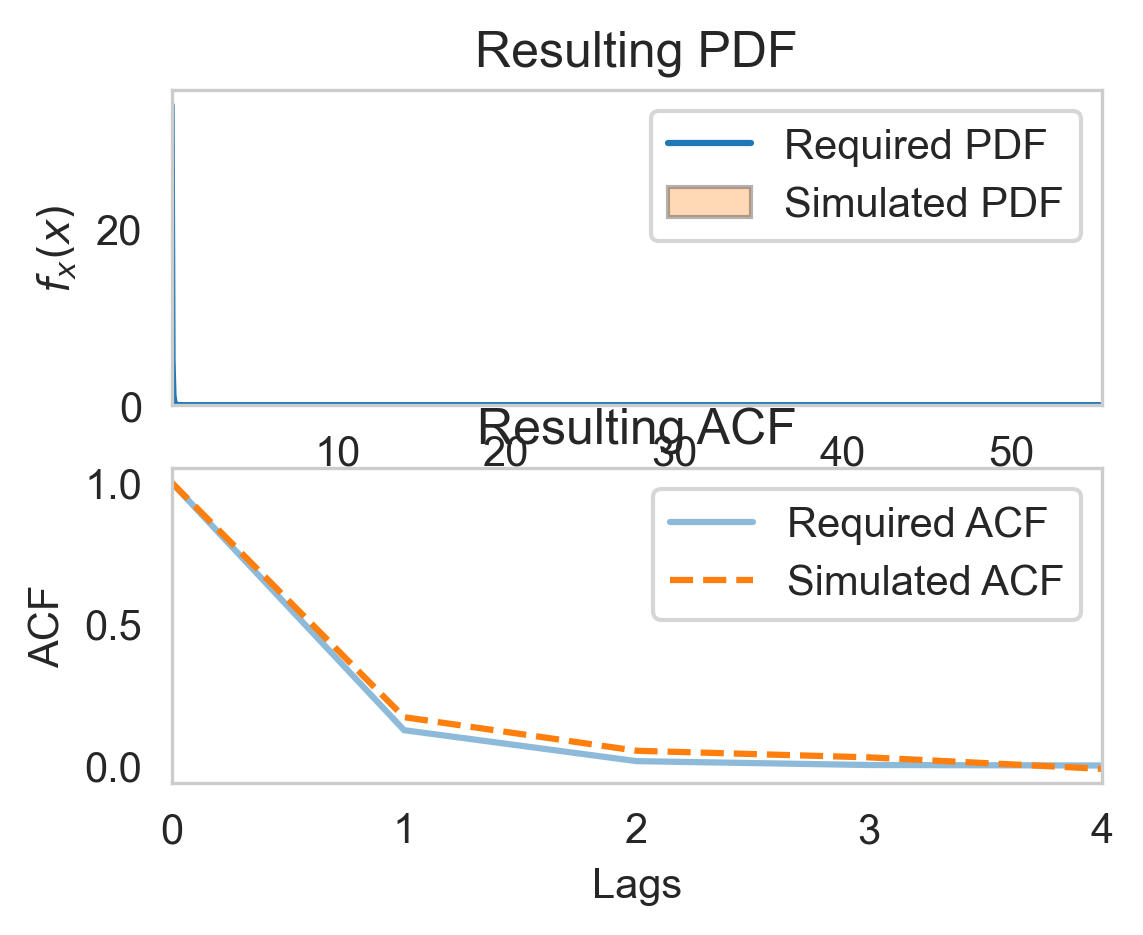

Mean 0.40 | Jitter 0.08 | ACF 0.12


/Users/molguin/.venvs/EdgeDroid/lib/python3.11/site-packages/generate_corr_sequence/generate_corr_sequence.py:46: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  I = quad(integration_function, integration_min, integration_max, args=(numberOfHermitePoly, dist_obj))


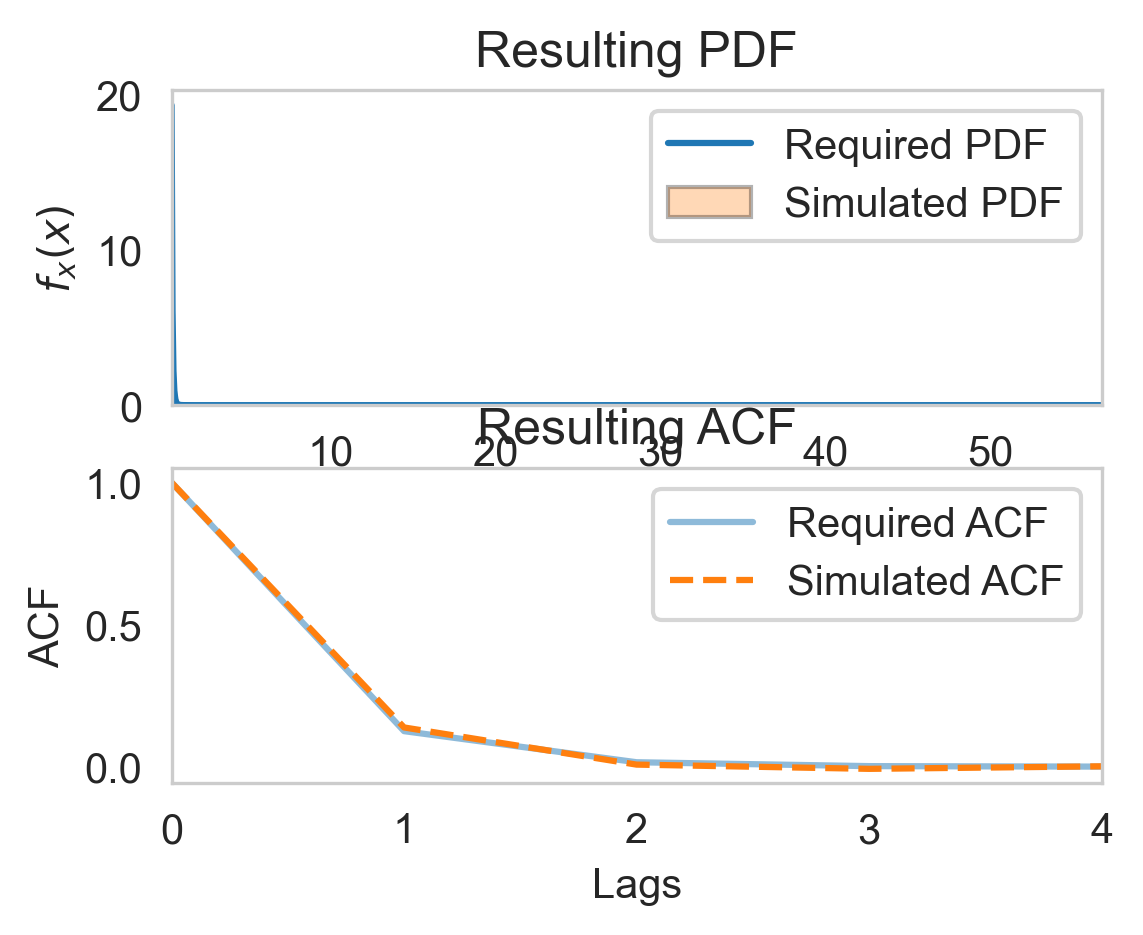

Mean 0.80 | Jitter 0.16 | ACF 0.12


/Users/molguin/.venvs/EdgeDroid/lib/python3.11/site-packages/generate_corr_sequence/generate_corr_sequence.py:46: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  I = quad(integration_function, integration_min, integration_max, args=(numberOfHermitePoly, dist_obj))


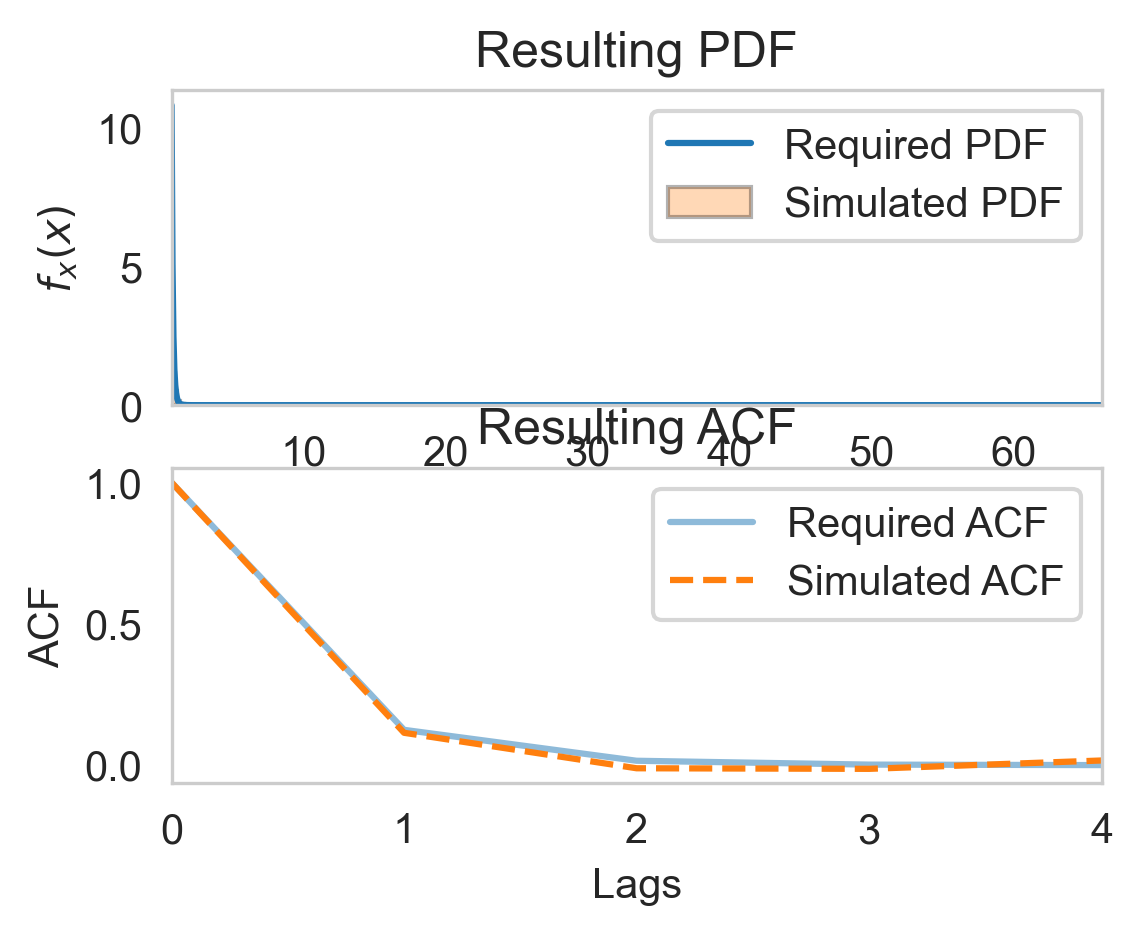

Mean 1.60 | Jitter 0.32 | ACF 0.12


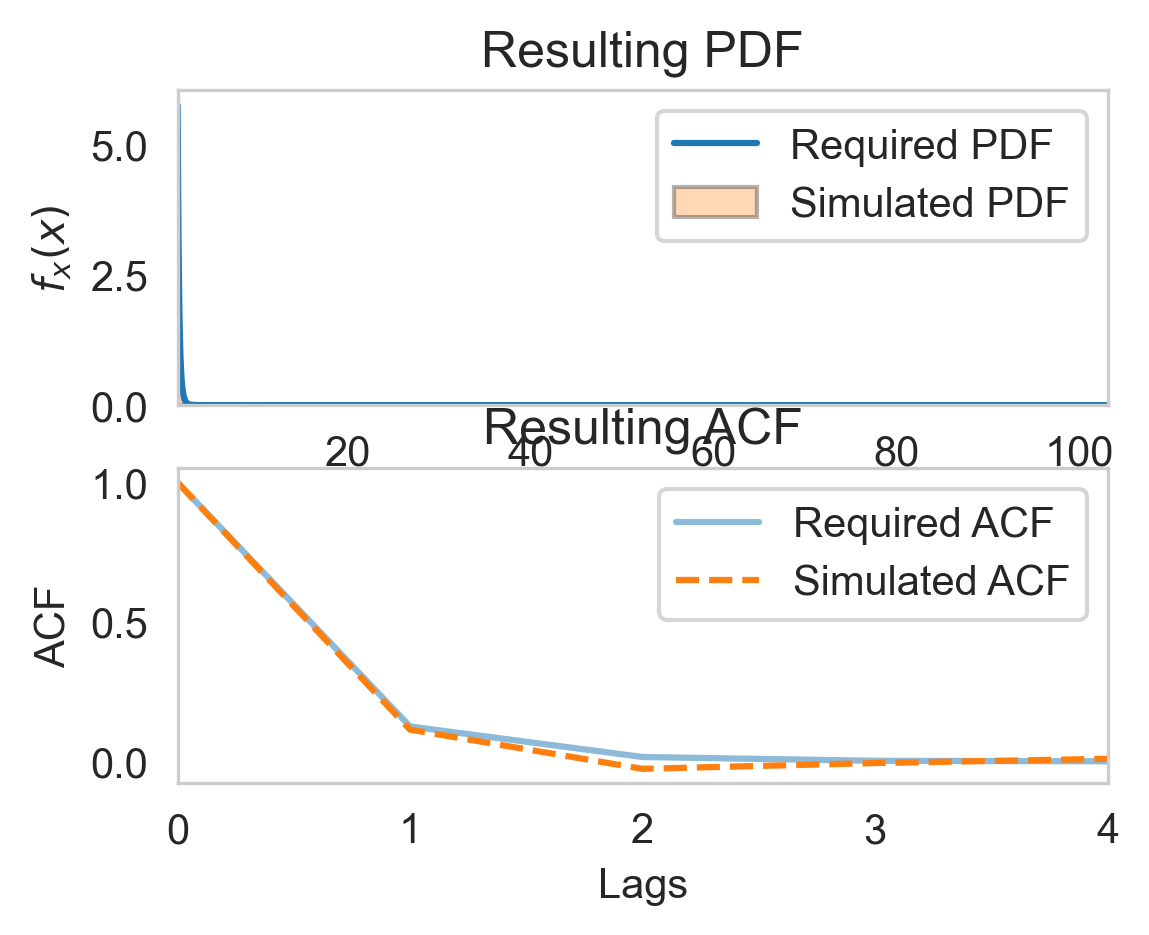

Mean 3.20 | Jitter 0.64 | ACF 0.12


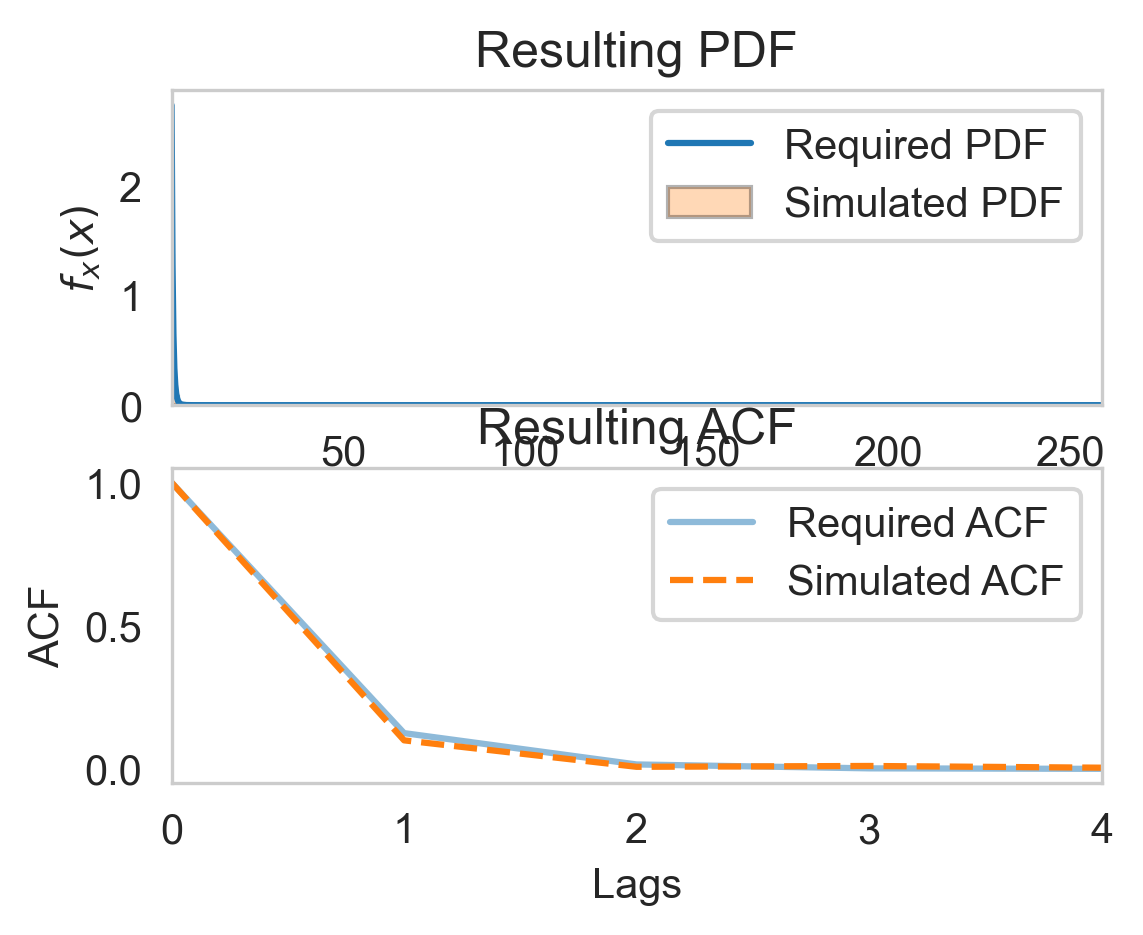

In [66]:
from generate_corr_sequence import gen_corr_sequence
import numpy as np
import itertools as it

acf_50 = 1 / (2 ** np.arange(5))  # 0.5 corr
acf_25 = 1 / (4 ** np.arange(5))
acf_12 = 1 / (8 ** np.arange(5))

for acf, ((mean, jitter), df) in it.product((acf_50, acf_25, acf_12), fits_df.groupby(["mean", "jitter"])):
    dist = st.pareto(scale=df["scale"], b=df["shape"])
    print(f"Mean {mean:0.02f} | Jitter {jitter:0.02f} | ACF {acf[1]:0.02f}")
    seq = gen_corr_sequence(
        dist_obj=dist,
        L=5000,
        target_acf=acf,
        debug=True,
    )




In [71]:
fits_df.to_latex(
    
)

,mean,jitter,shape,scale
0,0.1,0.02,4.497600,0.088346
1,0.2,0.04,6.257237,0.177206
2,0.4,0.08,6.836943,0.351322
3,0.8,0.16,7.751845,0.701636
4,1.6,0.32,7.689716,1.394286
5,3.2,0.64,7.592262,2.783705
